In [1]:
# works in snap36 env with python 3.6
# analog to tutorial pdf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

import snappy
from snappy import Product
from snappy import ProductIO
from snappy import ProductUtils
from snappy import WKTReader
from snappy import HashMap
from snappy import GPF

In [2]:
path_to_sentinel_data = r"C:\Users\pc\Desktop\wktests\wk200\S1A_IW_GRDH_1SDV_20191128T170907_20191128T170932_030114_0370BD_F250.SAFE"
product = ProductIO.readProduct(path_to_sentinel_data)


In [3]:
width = product.getSceneRasterWidth()
print("Width: {} px".format(width))
height = product.getSceneRasterHeight()
print("Height: {} px".format(height))
name = product.getName()
print("Name: {}".format(name))
band_names = product.getBandNames()
print("Band names: {}".format(", ".join(band_names)))

Width: 26125 px
Height: 16692 px
Name: S1A_IW_GRDH_1SDV_20191128T170907_20191128T170932_030114_0370BD_F250
Band names: Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV


In [4]:
def plotBand(product, band, vmin, vmax):
    band = product.getBand(band)
    w = band.getRasterWidth()
    h = band.getRasterHeight()
    print(w, h)
    
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    
    band_data.shape = h, w
    
    width = 12
    height = 12
    
    plt.figure(figsize=(width, height))
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax)
    
    return imgplot

In [5]:
# set wkt


wkt = "POLYGON((7.62 54.329, 7.801 54.329, 7.801 54.484, 7.62 54.484, 7.62 54.329))"



In [6]:
# subset

parameters = HashMap()
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
parameters.put('orbitType', 'Sentinel Precise (Auto Download)')
parameters.put('polyDegree', '3')
parameters.put('continueOnFail', 'false')
apply_orbit_file = GPF.createProduct('Apply-Orbit-File', parameters, product)


SubsetOp = snappy.jpy.get_type('org.esa.snap.core.gpf.common.SubsetOp')
bounding_wkt = wkt
geometry = WKTReader().read(bounding_wkt)
HashMap = snappy.jpy.get_type('java.util.HashMap')
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geometry)
product_subset = snappy.GPF.createProduct('Subset', parameters,
apply_orbit_file)

In [7]:
width = product_subset.getSceneRasterWidth()
print("Width: {} px".format(width))
height = product_subset.getSceneRasterHeight()
print("Height: {} px".format(height))
band_names = product_subset.getBandNames()
print("Band names: {}".format(", ".join(band_names)))



Width: 1494 px
Height: 1712 px
Band names: Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV


1494 1712


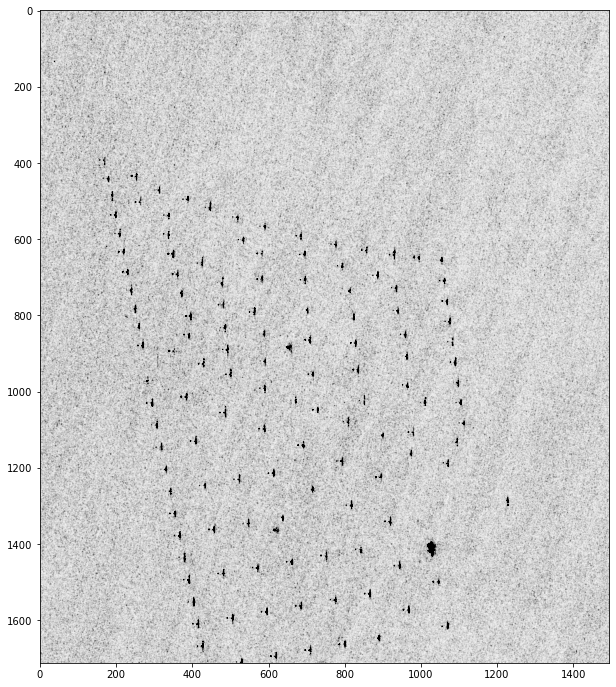

In [14]:
plotBand(product_subset, "Intensity_VV", 0, 100000)

3097 1991


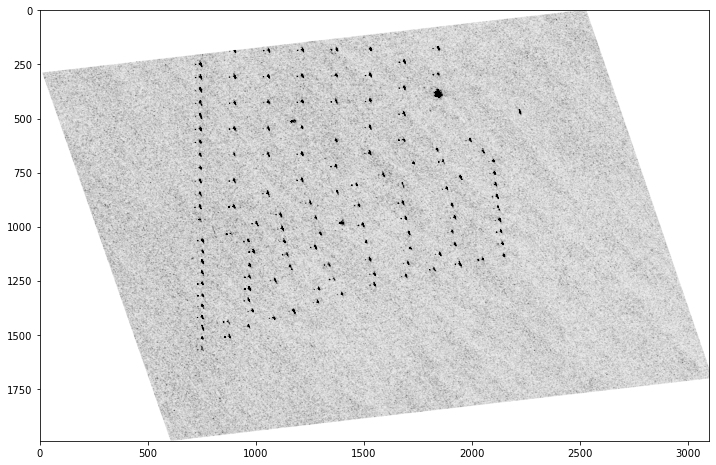

In [15]:
# terrain correction

parameters = HashMap()
parameters.put('demName', 'SRTM 3Sec')
parameters.put('pixelSpacingInMeter', 10.0)
parameters.put('sourceBands', "Intensity_VV")
parameters.put('nodataValueAtSea', "False")    # hier false damit wasser-gebiete nicht rausgeschmissen werden
product_subset_corrected = GPF.createProduct("Terrain-Correction", parameters,
product_subset)
korrigiert = plotBand(product_subset_corrected, "Intensity_VV", 0, 100000)

# saves in skript folder
korrigiert.write_png('korrigiert.png')




In [10]:
# just checking operator-parameter


def get_snap_info(operator):
    """
    Returns information about SNAP operators and their parameters
    """
    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator)
    print('Op name:', op_spi.getOperatorDescriptor().getName())
    print('Op alias:', op_spi.getOperatorDescriptor().getAlias()) 
    param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
    for param in param_Desc:
          print(param.getName(), "or", param.getAlias())
            
get_snap_info("Terrain-Correction")            

Op name: org.esa.s1tbx.sar.gpf.geometric.RangeDopplerGeocodingOp
Op alias: Terrain-Correction
sourceBandNames or sourceBands
demName or None
externalDEMFile or None
externalDEMNoDataValue or None
externalDEMApplyEGM or None
demResamplingMethod or None
imgResamplingMethod or None
pixelSpacingInMeter or None
pixelSpacingInDegree or None
mapProjection or None
alignToStandardGrid or None
standardGridOriginX or None
standardGridOriginY or None
nodataValueAtSea or None
saveDEM or None
saveLatLon or None
saveIncidenceAngleFromEllipsoid or None
saveLocalIncidenceAngle or None
saveProjectedLocalIncidenceAngle or None
saveSelectedSourceBand or None
outputComplex or None
applyRadiometricNormalization or None
saveSigmaNought or None
saveGammaNought or None
saveBetaNought or None
incidenceAngleForSigma0 or None
incidenceAngleForGamma0 or None
auxFile or None
externalAuxFile or None


In [11]:
# export as geotiff

ProductIO.writeProduct(product_subset, r"C:\Users\pc\Desktop\sicherheit\product_korrigiert",  'GeoTIFF')